In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from osgeo import gdal    ## used to read images in memory

import tensorflow as tf

################################################################
## Storing and timing Models
import pickle
from joblib import dump,load
import time

################################################################
# Custom functions from lib.py
from lib import dataExtract, dataStack, indicesFromDataStack, \
                stochasticPCAFromDataStack, stochasticICAFromDataStack, \
                stackToImage, featuresCompute, \
                vectorStackToImage, stackToImage2, preProcessImgs

################################################################
import warnings
warnings.filterwarnings("ignore")

################################################################

plotBool = 0


#### Display Data

In [2]:
if plotBool == 1:
    '''
    Extract Data
    '''
    colNames = ['coastal','blue','green','yellow','red','red edge','near IR1', 'near IR2','AGL','CLS']
    rawDataTrain = dataExtract(foldername='train')
    numImages = len(rawDataTrain)

    imgIdx = 1   ## index of image to plot

    fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(12,10))
    img = ax[0][0].imshow(rawDataTrain['MSI'][imgIdx][0].astype(np.uint8), cmap='Blues'); ax[0][0].set_title('Coastal: 400-450 nm'); fig.colorbar(img, ax=ax[0][0], fraction=0.05)
    img = ax[0][1].imshow(rawDataTrain['MSI'][imgIdx][1].astype(np.uint8), cmap='Blues'); ax[0][1].set_title('Blue: 450-510 nm'); fig.colorbar(img, ax=ax[0][1], fraction=0.05)
    img = ax[0][2].imshow(rawDataTrain['MSI'][imgIdx][2].astype(np.uint8), cmap='Greens'); ax[0][2].set_title('Green: 510-580 nm'); fig.colorbar(img, ax=ax[0][2], fraction=0.05)
    img = ax[1][0].imshow(rawDataTrain['MSI'][imgIdx][3].astype(np.uint8), cmap='YlOrRd_r'); ax[1][0].set_title('Yellow: 585-625 nm'); fig.colorbar(img, ax=ax[1][0], fraction=0.05)
    img = ax[1][1].imshow(rawDataTrain['MSI'][imgIdx][4].astype(np.uint8), cmap='Reds'); ax[1][1].set_title('Red: 630-690 nm'); fig.colorbar(img, ax=ax[1][1], fraction=0.05)
    img = ax[1][2].imshow(rawDataTrain['MSI'][imgIdx][5].astype(np.uint8), cmap='Reds'); ax[1][2].set_title('Red Edge: 705-745 nm'); fig.colorbar(img, ax=ax[1][2], fraction=0.05)
    img = ax[2][0].imshow(rawDataTrain['MSI'][imgIdx][6].astype(np.uint8), cmap='Oranges'); ax[2][0].set_title('near IR1: 770-895 nm'); fig.colorbar(img, ax=ax[2][0], fraction=0.05)
    img = ax[2][1].imshow(rawDataTrain['MSI'][imgIdx][7].astype(np.uint8), cmap='Oranges'); ax[2][1].set_title('near IR2: 860-1040 nm'); fig.colorbar(img, ax=ax[2][1], fraction=0.05)
    img = ax[2][2].imshow(rawDataTrain['AGL'][imgIdx].astype(np.uint8), cmap='gray'); ax[2][2].set_title('AGL'); fig.colorbar(img, ax=ax[2][2], fraction=0.05)

    fig.tight_layout()
    plt.savefig('./plots/rawData.svg')

    '''
    Compute Features
    '''
    dataTrain = dataStack(rawDataTrain)
    ## Compute features
    dataTrain = pd.DataFrame( np.array(dataTrain) , columns=colNames )
    # dataTrain = featuresCompute(dataTrain, numPCA=3, numICA=3 )
    print(f'Feature Names:\n{dataTrain.columns}')

    '''
    Remove Irrelevant Classes
    '''
    groundTruthCLS = np.array(dataTrain['CLS'])
    groundTruthCLS[np.where(groundTruthCLS==9)[0]] = 2
    groundTruthCLS[np.where(groundTruthCLS==17)[0]] = 2
    groundTruthCLS[np.where(groundTruthCLS==65)[0]] = 2
    groundTruthCLS[np.where(groundTruthCLS==2)[0]] = 0

    trainGroundTruth = vectorStackToImage(pd.DataFrame(groundTruthCLS,columns=['CLS']),colNames=['CLS'])
    del groundTruthCLS

    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
    img = ax[0].imshow((trainGroundTruth['CLS'][imgIdx]==6).astype(np.uint8), cmap='gray'); ax[0].set_title('Class Labels: \nBuildings (6)'); fig.colorbar(img, ax=ax[0], fraction=0.05)
    img = ax[1].imshow((trainGroundTruth['CLS'][imgIdx]==5).astype(np.uint8), cmap='Greens'); ax[1].set_title('Class Labels: \nTrees (5)'); fig.colorbar(img, ax=ax[1], fraction=0.05)
    img = ax[2].imshow((trainGroundTruth['CLS'][imgIdx]==0).astype(np.uint8), cmap='YlOrRd_r'); ax[2].set_title('Class Labels: \nOther (0)'); fig.colorbar(img, ax=ax[2], fraction=0.05)
    fig.tight_layout()
    plt.savefig('./plots/rawDataCLSReduced.svg')

    plt.show()


## Pre-Process Data
Labels: 6: Building, 3: Tree, 0: Other

In [3]:
XTrain,YTrain,cols = preProcessImgs(imgFolder='train',annotationFolder='trainImgCLS')

Computed Principal Components
Computed Independent Components
	Computed NDVI: Normalized Difference Vegetation Index
	Computed NDWI: Normalized Difference Water Index
	Computed BAI: Burned Area Index
	Computed BNDVI: Blue Normalized Difference Vegetation Index
	Computed CVI: Chlorophyll Vegetation Index
	Computed GNDVI: Green Normalized Difference Vegetation Index
	Computed YNDVI: Yellow Normalized Difference Vegetation Index
	Computed OSAVI: Optimized Soil-Adjusted Vegetation Index
Computed Indices
Feature Names:
Index(['coastal', 'blue', 'green', 'yellow', 'red', 'red edge', 'near IR1',
       'near IR2', 'AGL', 'PC0', 'PC1', 'PC2', 'IC0', 'IC1', 'IC2',
       'ndvi_NIR1', 'ndvi_NIR2', 'ndwi_NIR1', 'ndwi_NIR2', 'bai_NIR1',
       'bai_NIR2', 'bndvi_NIR1', 'bndvi_NIR2', 'cvi_NIR1', 'cvi_NIR2',
       'gndvi_NIR1', 'gndvi_NIR2', 'yndvi_NIR1', 'yndvi_NIR2', 'osavi_NIR1',
       'osavi_NIR2', 'CLS'],
      dtype='object')


In [4]:
XValid,YValid,cols = preProcessImgs(imgFolder='test2_assignment_2_sim',annotationFolder='validImgCLS')

Computed Principal Components
Computed Independent Components
	Computed NDVI: Normalized Difference Vegetation Index
	Computed NDWI: Normalized Difference Water Index
	Computed BAI: Burned Area Index
	Computed BNDVI: Blue Normalized Difference Vegetation Index
	Computed CVI: Chlorophyll Vegetation Index
	Computed GNDVI: Green Normalized Difference Vegetation Index
	Computed YNDVI: Yellow Normalized Difference Vegetation Index
	Computed OSAVI: Optimized Soil-Adjusted Vegetation Index
Computed Indices
Feature Names:
Index(['coastal', 'blue', 'green', 'yellow', 'red', 'red edge', 'near IR1',
       'near IR2', 'AGL', 'PC0', 'PC1', 'PC2', 'IC0', 'IC1', 'IC2',
       'ndvi_NIR1', 'ndvi_NIR2', 'ndwi_NIR1', 'ndwi_NIR2', 'bai_NIR1',
       'bai_NIR2', 'bndvi_NIR1', 'bndvi_NIR2', 'cvi_NIR1', 'cvi_NIR2',
       'gndvi_NIR1', 'gndvi_NIR2', 'yndvi_NIR1', 'yndvi_NIR2', 'osavi_NIR1',
       'osavi_NIR2', 'CLS'],
      dtype='object')


In [5]:
# XTest,YTest,cols = preProcessImgs(imgFolder='test1',annotationFolder='testImgCLS')

In [6]:
def subimagesDataset(dataset,subimgSize=(256,256)):
    def subimages(img,subimgSize):
        imgList = []
        for i in range(0,img.shape[0],subimgSize[0]):
            for j in range(0,img.shape[1],subimgSize[1]):
                imgList.append(img[0+i:i+subimgSize[0],0+j:j+subimgSize[1]])
        return np.array(imgList).astype(np.float32)
    
    subimagesAll = subimages(dataset[0],subimgSize)   
    for img in dataset[1:]:
        subimagesAll = np.concatenate((subimagesAll,subimages(img,subimgSize)) , axis=0)
    return subimagesAll

In [7]:
## Training Set
# subimagesXTrain = subimages(XTrain[0],subimgSize=(256,256))   
# for img in XTrain[1:]:
#     subimagesXTrain = np.concatenate((subimagesXTrain,subimages(img,subimgSize=(256,256))) , axis=0)
# subimagesYTrain = subimages(YTrain[0],subimgSize=(256,256))   

# for img in YTrain[1:]:
#     subimagesYTrain = np.concatenate((subimagesYTrain,subimages(img,subimgSize=(256,256))) , axis=0)
XTrain = subimagesDataset(XTrain,subimgSize=(256,256))
YTrain = subimagesDataset(YTrain,subimgSize=(256,256))

print(XTrain.shape)
print(YTrain.shape)

(496, 256, 256, 32)
(496, 256, 256)


In [8]:
## Validation Set
# subimagesXValid = subimages(XValid[0],subimgSize=(256,256))   
# for img in XValid[1:]:
#     subimagesXValid = np.concatenate((subimagesXValid,subimages(img,subimgSize=(256,256))) , axis=0)

# subimagesYValid = subimages(YValid[0],subimgSize=(256,256))   
# for img in YValid[1:]:
#     subimagesYValid = np.concatenate((subimagesYValid,subimages(img,subimgSize=(256,256))) , axis=0)
# XValid = subimagesXValid
# YValid = subimagesYValid
XValid = subimagesDataset(XValid,subimgSize=(256,256))
YValid = subimagesDataset(YValid,subimgSize=(256,256))

print(XValid.shape)
print(YValid.shape)

(160, 256, 256, 32)
(160, 256, 256)


# U-NET

### Model: Definition

In [91]:
from tensorflow.keras.layers import Input,Conv2D,BatchNormalization,Activation,MaxPool2D,UpSampling2D,Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

def conv_block(inputs,filters,pool=True):
    x = Conv2D(filters,3,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2,2))(x)
        return x,p
    else:
        return x

def build_unet(shape,num_classes):
    inputs = Input(shape)

    """Encoder"""
    x1,p1 = conv_block(inputs,4,pool=True)
    x2,p2 = conv_block(p1,8,pool=True)
    x3,p3 = conv_block(p2,16,pool=True)
    x4,p4 = conv_block(p3,32,pool=True)
    
    """Bridge"""
    b1 = conv_block(p4,64,pool=False)

    """Decoder"""    
    u1 = UpSampling2D((2,2),interpolation="bilinear")(b1)
    c1 = Concatenate()([u1,x4])
    x5 = conv_block(c1,32,pool=False)

    u2 = UpSampling2D((2,2),interpolation="bilinear")(x5)
    c2 = Concatenate()([u2,x3])
    x6 = conv_block(c2,16,pool=False)
    
    u3 = UpSampling2D((2,2),interpolation="bilinear")(x6)
    c3 = Concatenate()([u3,x2])
    x7 = conv_block(c3,8,pool=False)

    u4 = UpSampling2D((2,2),interpolation="bilinear")(x7)
    c4 = Concatenate()([u4,x1])
    x8 = conv_block(c4,4,pool=False)
    
    
    """Output"""
    output = Conv2D(num_classes, 1,padding='same',activation="softmax")(x8)

    return Model(inputs,output)

if __name__ == "__main__":
    model = build_unet((256,256,32),3)
    print(model.summary())


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 32 0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 256, 256, 4)  1156        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_126 (BatchN (None, 256, 256, 4)  16          conv2d_133[0][0]                 
__________________________________________________________________________________________________
activation_126 (Activation)     (None, 256, 256, 4)  0           batch_normalization_126[0][0]    
____________________________________________________________________________________________

### Model: Implementation

In [96]:
H = 256
W = 256
numClasses = 3
numFeatures = len(cols)
batchsize=8
lr = 1e-3
epochs=15
shape = (H,W,numFeatures)

def preprocess(x,y):
    image = tf.convert_to_tensor(x.astype(np.float32), dtype=tf.float32)
    mask = tf.convert_to_tensor(y.astype(np.int32), dtype=tf.int32)
    mask = tf.one_hot(mask,numClasses,dtype=tf.int32)
    image.set_shape([len(x),H,W,numFeatures])
    mask.set_shape([len(x),H,W,numClasses])
    return image,mask

def tf_dataset(x,y,batch=8):
    X0,Y0 = preprocess(x,y)
    dataset = tf.data.Dataset.from_tensor_slices((X0,Y0))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset


In [97]:
train_dataset = tf_dataset(np.nan_to_num(XTrain,nan=0),YTrain,batch=batchsize)
valid_dataset = tf_dataset(np.nan_to_num(XValid,nan=0),YValid,batch=batchsize)

print('Training Batches')
for x,y in train_dataset:
    print(x.shape,y.shape)
print('\nValidation Batches')
for x,y in valid_dataset:
    print(x.shape,y.shape)

Training Batches
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8, 256, 256, 32) (8, 256, 256, 3)
(8,

In [98]:
YTrain.shape

(496, 256, 256)

#### Training

In [99]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

""" U-Net Model """
model = build_unet(shape,numClasses)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(lr))

train_steps = len(XTrain)//batchsize
valid_steps = len(XValid)//batchsize

callbacks = [
    ModelCheckpoint("modelUnet.h5",verbose=1,save_best_model=True),
    ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1,verbose=1,min_lr=1e-6),
    EarlyStopping(monitor='val_loss',patience=5,verbose=1)
]

model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/15
62/62 [==============================] - 15s 189ms/step - loss: 0.6398 - val_loss: 10.1310

Epoch 00001: saving model to modelUnet.h5
Epoch 2/15
62/62 [==============================] - 13s 183ms/step - loss: 0.4713 - val_loss: 0.4734

Epoch 00002: saving model to modelUnet.h5
Epoch 3/15
62/62 [==============================] - 14s 198ms/step - loss: 0.3774 - val_loss: 0.3233

Epoch 00003: saving model to modelUnet.h5
Epoch 4/15
62/62 [==============================] - 15s 210ms/step - loss: 0.3053 - val_loss: 0.3934

Epoch 00004: saving model to modelUnet.h5
Epoch 5/15
62/62 [==============================] - 14s 195ms/step - loss: 0.2487 - val_loss: 0.2855

Epoch 00005: saving model to modelUnet.h5
Epoch 6/15
62/62 [==============================] - 14s 198ms/step - loss: 0.2037 - val_loss: 0.2072

Epoch 00006: saving model to modelUnet.h5
Epoch 7/15
62/62 [==============================] - 13s 189ms/step - loss: 0.1682 - val_loss: 0.3257

Epoch 00007: saving model to mode

In [100]:
model = tf.keras.models.load_model('modelUnet.h5')
predictionsSoftmax = model.predict(XValid)
predictions = np.argmax(predictionsSoftmax, axis=-1)

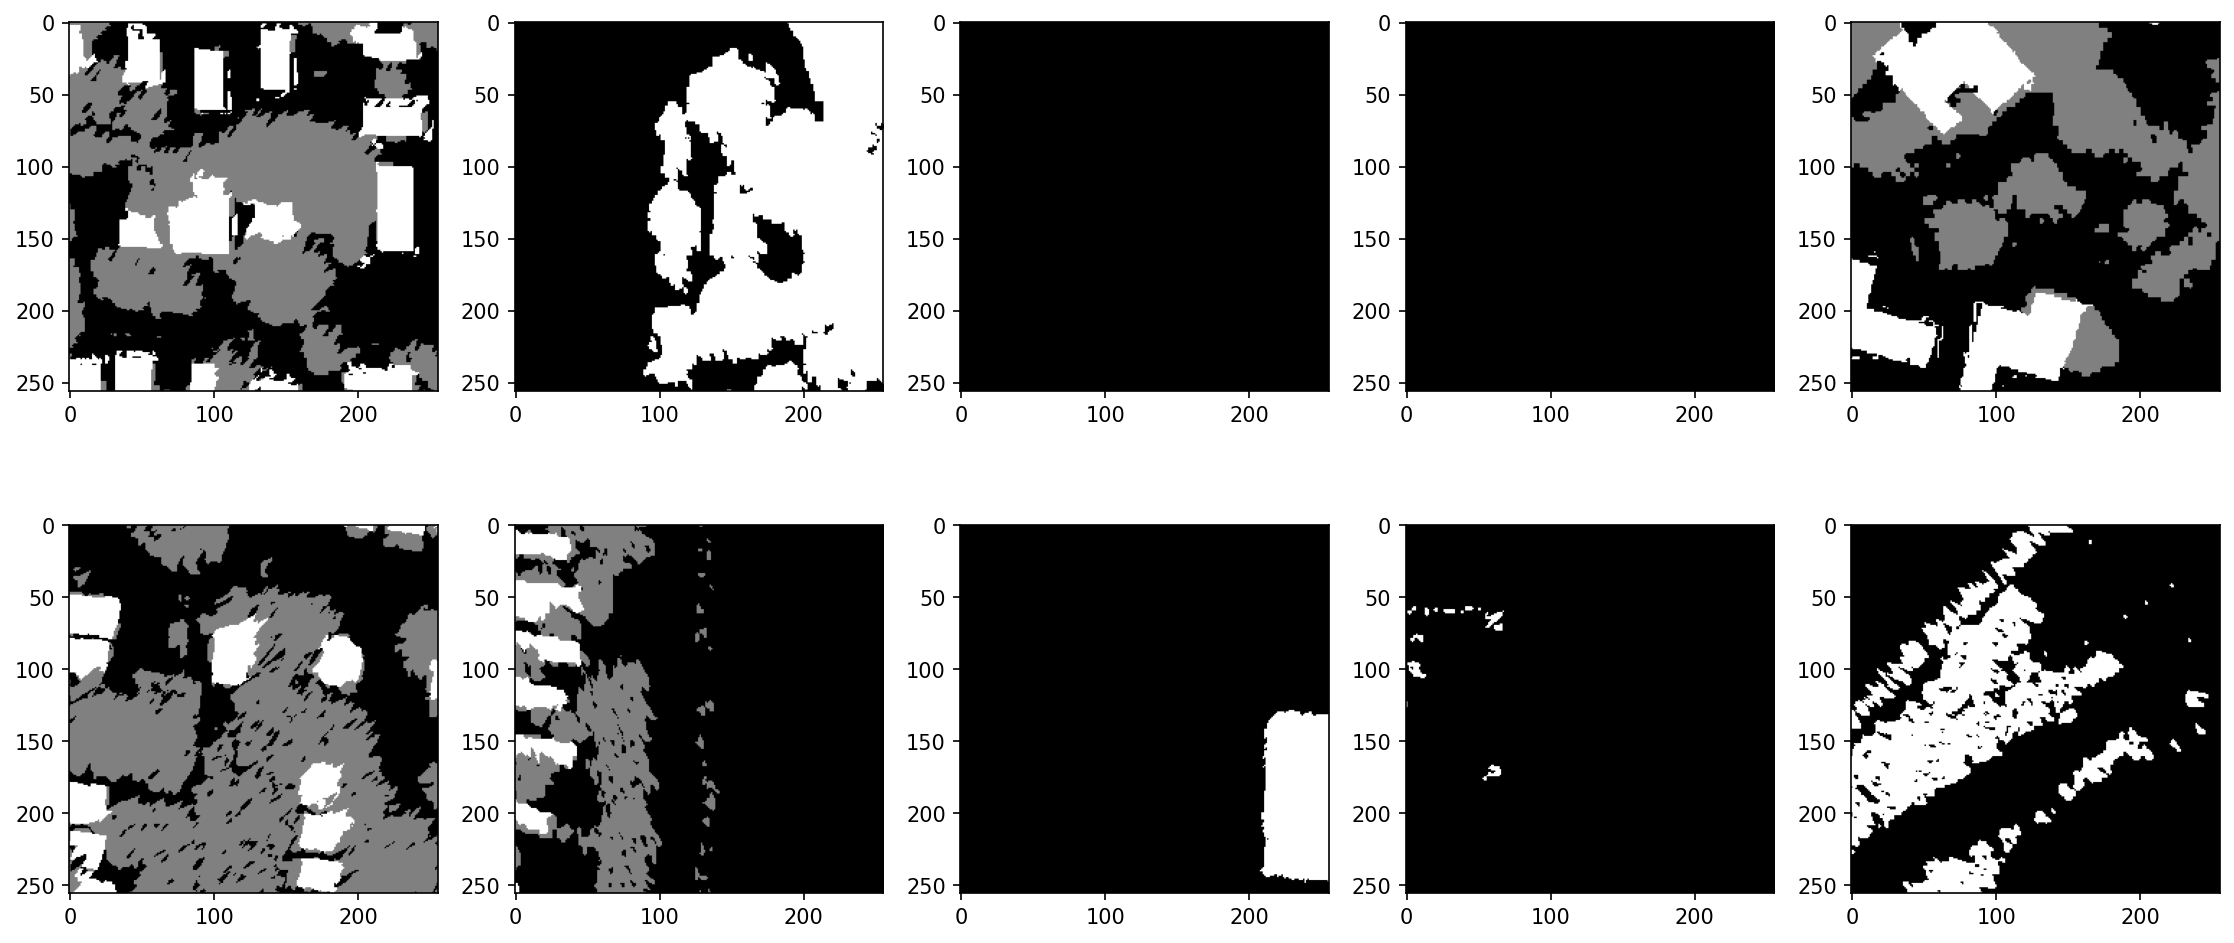

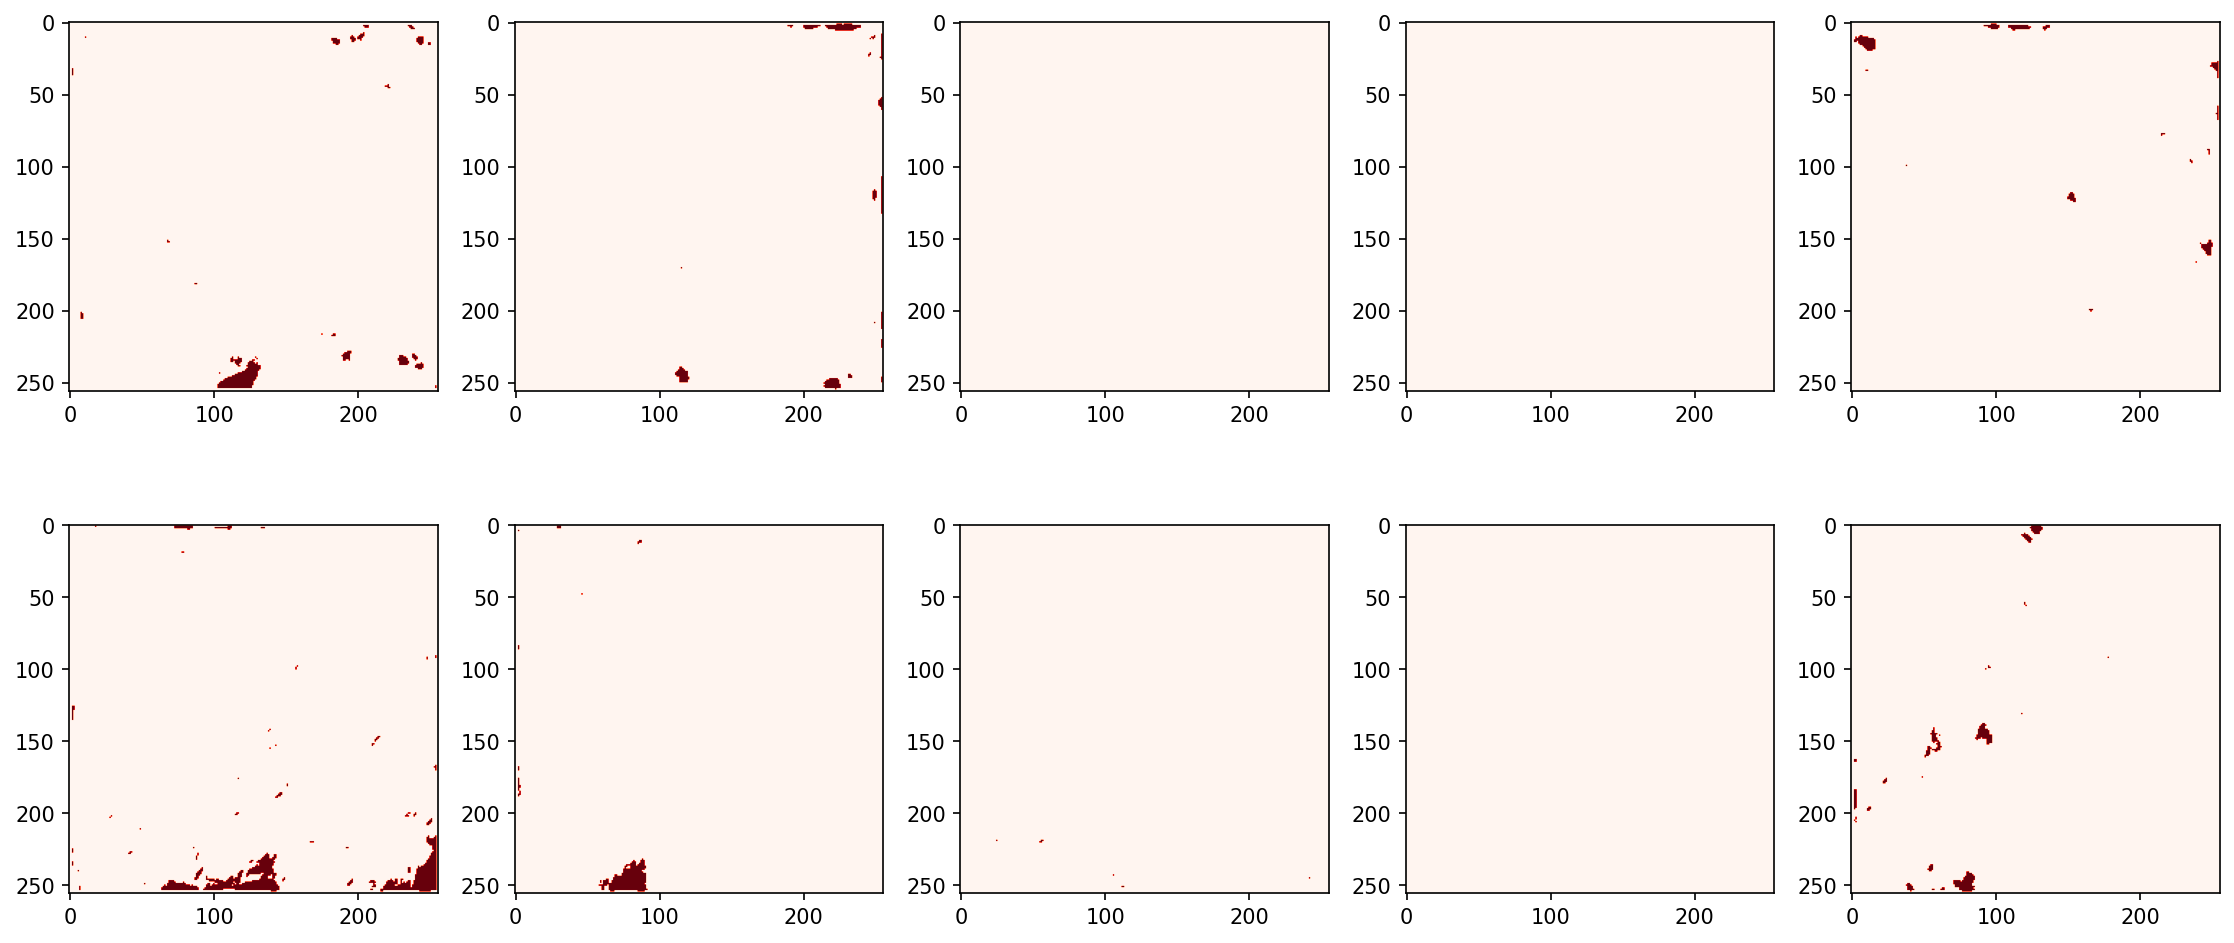

In [101]:
fig,ax = plt.subplots(nrows=2,ncols=np.ceil(len(YValid)/32).astype(int),figsize=(15,7),dpi=150)
ax = ax.reshape(-1)
i=0
for imgIdx in range(3,len(YValid),16):
    ax[i].imshow(YValid[imgIdx],cmap='gray')
    # plt.colorbar()
    i=i+1
fig.tight_layout()
plt.show()

fig,ax = plt.subplots(nrows=2,ncols=np.ceil(len(YValid)/32).astype(int),figsize=(15,7),dpi=150)
ax = ax.reshape(-1)
i=0
for imgIdx in range(3,len(YValid),16):
    ax[i].imshow(predictions[imgIdx],cmap='Reds')
    # plt.colorbar()
    i=i+1
fig.tight_layout()
plt.show()

In [62]:
len(ax)

16

In [76]:
predictionsSoftmax[0]

array([[[0.44762897, 0.22463593, 0.3277351 ],
        [0.45344886, 0.261779  , 0.28477222],
        [0.49778646, 0.21943544, 0.28277805],
        ...,
        [0.5127737 , 0.2453943 , 0.24183205],
        [0.49643254, 0.27275512, 0.2308123 ],
        [0.5239169 , 0.23318617, 0.2428969 ]],

       [[0.41227576, 0.27842644, 0.30929783],
        [0.5064671 , 0.25082552, 0.24270739],
        [0.52645147, 0.21969317, 0.25385532],
        ...,
        [0.53663033, 0.18478878, 0.2785809 ],
        [0.5002432 , 0.20547497, 0.29428184],
        [0.5598315 , 0.17996573, 0.26020277]],

       [[0.4105431 , 0.29615155, 0.2933053 ],
        [0.5220727 , 0.23935476, 0.23857258],
        [0.5534411 , 0.21901745, 0.22754142],
        ...,
        [0.5672917 , 0.20049891, 0.23220941],
        [0.5722879 , 0.19713159, 0.23058042],
        [0.5697478 , 0.1759116 , 0.2543406 ]],

       ...,

       [[0.45438918, 0.28985763, 0.2557532 ],
        [0.53715694, 0.22323784, 0.23960522],
        [0.5404643 , 0

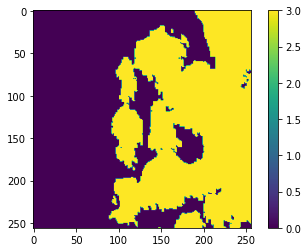

In [84]:
plt.imshow(YValid[19])
plt.colorbar()